In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import sagemaker.amazon.common as smac
import os

%matplotlib inline

In [4]:
df = pd.read_csv('salary.csv')

In [5]:
df.head()

,YearsExperience,Salary
0,1.1,39343
1,1.3,46205
2,1.5,37731
3,2.0,43525
4,2.2,39891


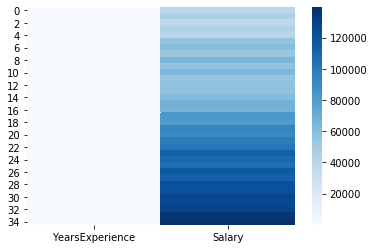

In [7]:
sns.heatmap(df,cmap='Blues')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   YearsExperience  35 non-null     float64
 1   Salary           35 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 688.0 bytes


In [9]:
df.describe()

,YearsExperience,Salary
count,35.000000,35.000000
mean,6.308571,83945.600000
std,3.618610,32162.673003
min,1.100000,37731.000000
25%,3.450000,57019.000000
50%,5.300000,81363.000000
75%,9.250000,113223.500000
max,13.500000,139465.000000


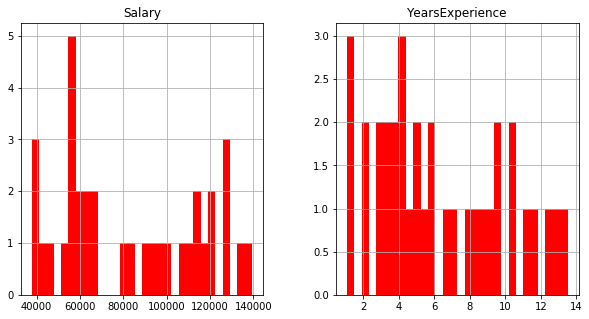

In [18]:
df.hist(bins=30,figsize=(10,5),color='r')
plt.show()

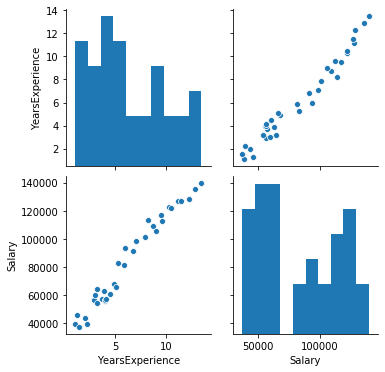

In [15]:
sns.pairplot(df)

In [20]:
df[df['Salary'] == df['Salary'].max()]

,YearsExperience,Salary
34,13.5,139465


In [21]:
df[df['Salary'] == df['Salary'].min()]

,YearsExperience,Salary
2,1.5,37731


In [22]:
df.corr()

,YearsExperience,Salary
YearsExperience,1.000000,0.982427
Salary,0.982427,1.000000


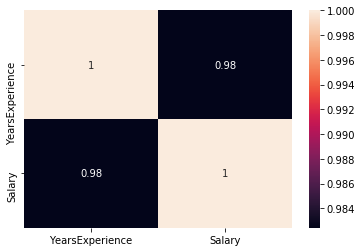

In [27]:
sns.heatmap(df.corr(),annot=True)
plt.show()

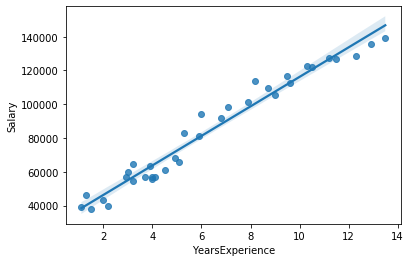

In [31]:
sns.regplot(y=df['Salary'],x=df['YearsExperience'],x_ci='ci')
plt.show()

In [35]:
X = df[['YearsExperience']]
y = df[['Salary']]

In [38]:
X.head()

,YearsExperience
0,1.1
1,1.3
2,1.5
3,2.0
4,2.2


In [39]:
y.head()

,Salary
0,39343
1,46205
2,37731
3,43525
4,39891


In [40]:
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,accuracy_score

In [57]:
model = LinearRegression(fit_intercept=True)
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [58]:
print(f'Linear model intercept: {model.intercept_}')
print(f'Linear model coeff: {model.coef_}')

Linear model intercept: [29445.05]
Linear model coeff: [[8629.793]]


In [59]:
model.score(X_test,y_test)

0.9708090543515319

In [60]:
y_pred = model.predict(X_test)

In [63]:
mean_squared_error(y_test,y_pred)

16561674.0

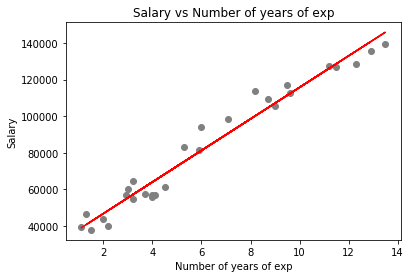

In [68]:
plt.scatter(X_train,y_train,color='gray')
plt.plot(X_train,model.predict(X_train),color='red')
plt.ylabel('Salary')
plt.xlabel('Number of years of exp')
plt.title('Salary vs Number of years of exp')
plt.show()

In [70]:
model.predict([[5]])

array([[72594.015625]])

In [71]:
import sagemaker
import boto3

In [72]:
sage_session = sagemaker.Session()

In [79]:
bucket = 'sagemaker-studio-375165215765-1avcjmm8wqj'
prefix = 'linear_learner'
region = 'us-east-1'

In [74]:
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::375165215765:role/service-role/AmazonSageMaker-ExecutionRole-20210112T113360


In [75]:
X_train.shape

(28, 1)

In [76]:
y_train = y_train[:,0]

In [78]:
y_train.shape

(28,)

In [83]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf,X_train,y_train)
buf.seek(0)

0

In [85]:
key = 'linear-train-data'

In [86]:
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix,'train',key)).upload_fileobj(buf)

In [89]:
s3_train_data = 's3://{}/{}/train/{}'.format(bucket,prefix,key)

In [90]:
s3_train_data

's3://sagemaker-studio-375165215765-1avcjmm8wqj/linear_learner/train/linear-train-data'

In [91]:
output_location = 's3://{}/{}/output'.format(bucket,prefix)
output_location

's3://sagemaker-studio-375165215765-1avcjmm8wqj/linear_learner/output'

In [94]:
from sagemaker.image_uris import retrieve

In [95]:
container = retrieve('linear-learner',region=region)

In [104]:
linear = sagemaker.estimator.Estimator(container,role,instance_count=1,
                                      instance_type='ml.c4.xlarge',
                                      output_path=output_location,
                                      sagemaker_session=sage_session,
                                      use_spot_instances=True,
                                      max_run=300,
                                      max_wait=600)

In [105]:
linear.set_hyperparameters(feature_dim=1,
                          predictor_type='regressor',
                          mini_batch_size=5,
                          epochs=50,
                          num_models=32,
                          loss='absolute_loss')

In [106]:
linear.fit({'train':s3_train_data})

2021-01-13 12:00:28 Starting - Starting the training job...
2021-01-13 12:00:31 Starting - Launching requested ML instancesProfilerReport-1610539228: InProgress
......
2021-01-13 12:01:48 Starting - Preparing the instances for training.........
2021-01-13 12:03:30 Downloading - Downloading input data...
2021-01-13 12:03:54 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/13/2021 12:03:59 INFO 140290924971840] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto

In [119]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

linear_regressor = linear.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge',serializer=CSVSerializer(),
                                deserializer=JSONDeserializer())

-------------------!

In [120]:
result = linear_regressor.predict(X_test)

In [121]:
result

{'predictions': [{'score': 125400.15625},
  {'score': 92802.171875},
  {'score': 77824.71875},
  {'score': 123638.109375},
  {'score': 102493.46875},
  {'score': 76062.671875},
  {'score': 67252.3984375}]}

In [122]:
predictions = np.array([r['score'] for r in result['predictions']])

In [123]:
predictions

array([125400.15625  ,  92802.171875 ,  77824.71875  , 123638.109375 ,
       102493.46875  ,  76062.671875 ,  67252.3984375])

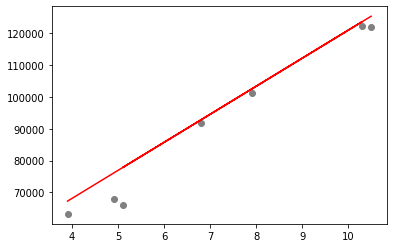

In [124]:
plt.scatter(X_test,y_test,color='gray')
plt.plot(X_test,predictions,color='red')

In [125]:
linear_regressor.delete_endpoint()